# Estimación del Precio Spot (Bid)


## Realizado por: Luis Mendoza Montero

***Desarrollo del trabajo:***

1. Cargar paquetes
2. Selección de parámetros
3. Preprocesado de datos
4. Estimación del precio Spot (bid)



# 1. Cargar paquetes

In [1]:
import sqlite3
import csv
import sys
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob; from os.path import expanduser
from datetime import datetime, date, time, timedelta
import calendar


--------------------------------------------------------------------------------------------------------------------------------

# 2. Selección de Parámetros

### Seleccionar region y categoría (tabla de la BBDD)

In [2]:
region = "'C4_ap_southeast_2'"

### Seleccionar tipo de Sistema Operativo

Existes 3 tipos de sistemas: ***Windows, Linux/UNIX o SUSE Linux***

In [3]:
sistema = "SUSE Linux"

Sacamos las zonas de disponibilidad, los sistemas operativos y las fechas de las instancias

In [4]:
# Conectar con la base de datos
with sqlite3.connect("BBDD.db") as connection:
    
    # Sacamos el tipo de istancia (nombre + familia)
    instances = pd.read_sql("SELECT DISTINCT InstanceType FROM "+region+";", connection) 
    instances_list = instances.values.tolist()
    del instances_list[0]
    
    for inst in instances_list:
        instance=inst[0] # En la variable instance tenemos el tipo de instancia
    print(instance)
    
    # Sacamos las zonas de disponibilidad
    zones = pd.read_sql("SELECT DISTINCT AvailabilityZone FROM "+region+";", connection) 
    zones_list = zones.values.tolist()
    del zones_list[0]
    
    listaRegiones = []
    for zone in zones_list:
        for zo in zone:
            listaRegiones.append(zo) # Lista de zonas en la región
    
    # Para cada zona y SO indicado sacamos el dia, el mes y el año
    for zona in listaRegiones: 
        #for sistema in listaSistemas:
        dates = pd.read_sql("SELECT DISTINCT SUBSTR(Timestamp, 1, 10) FROM "+region+"WHERE AvailabilityZone = '"+zona+"'AND Description = '"+sistema+"';", connection)
        dates_list = dates.values.tolist()
    
    listaFechas = []
    for date in dates_list:
        for da in date:
            listaFechas.append(da) # Lista de fechas en cada zona y SO

# Cerrar la conexión siempre
connection.close()

c4.2xlarge


### Seleccionar Zona de Disponibilidad

Elegir entre una de las siguientes zonas de disponibilidad:

In [5]:
print(listaRegiones)

['ap-southeast-2a', 'ap-southeast-2b', 'ap-southeast-2c']


In [6]:
zona = "ap-southeast-2b"

### Seleccionar fecha inicio y fin (desde 2018-01-24 hasta 2018-06-30 )

In [7]:
f_inicio = '2018-04-15'
f_final = '2018-08-15'

### Factor de olvido para Exponential Smoothing

In [8]:
landa = 0.85

### Horas ininterrumpidas por el usuario

In [9]:
duracion = 12

### Nivel de confianza (Probabilidad)

In [10]:
alpha = 0

--------------------------------------------------------------------------------------------------------------------------------

# 3. Preprocesado de datos

In [11]:

# Conectar con la base de datos, si no existe la crea automáticamente
conexion = sqlite3.connect("BBDD.db")
    
# Para poder ejecutar código SQL, tenemos que crear un cursor primero, el nombre de la tabla será la familia de las categorías
cursor = conexion.cursor()
cursor.execute("DROP TABLE IF EXISTS Preprocesados;")
cursor.execute("CREATE TABLE IF NOT EXISTS Preprocesados (AvailabilityZone VARCHAR(100), Description VARCHAR(100), InstanceType VARCHAR(100), SpotPrice FLOAT(8,4), Timestamp Datetime, PRIMARY KEY('AvailabilityZone','InstanceType','Timestamp','Description'))")

# Insertamos los nombre de los atributos para que se tenga en cuenta en formato csv
cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ('AvailabilityZone','Description','InstanceType','SpotPrice','Timestamp');")      

lista = [] # variable auxiliar por si no hay precios en algunas horas para meter el anterior más mayor
lista.append(0.0)
aux = '0'
#for zona in listaRegiones:
for fecha in listaFechas:
            
            # Para las 00:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T00:00:00.000z' AND Timestamp <='"+fecha+"T00:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T00:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T00:00:00.000Z');")
                aux = str(precio)
                
            # Para las 01:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T01:00:00.000z' AND Timestamp <='"+fecha+"T01:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T01:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T01:00:00.000Z');")
                aux = str(precio)
           
            # Para las 02:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T02:00:00.000z' AND Timestamp <='"+fecha+"T02:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T02:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T02:00:00.000Z');")
                aux = str(precio)

                
            # Para las 03:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T03:00:00.000z' AND Timestamp <='"+fecha+"T03:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T03:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T03:00:00.000Z');")
                aux = str(precio)
    
                
            # Para las 04:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T04:00:00.000z' AND Timestamp <='"+fecha+"T04:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T04:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T04:00:00.000Z');")
                aux = str(precio)
                    
            
            # Para las 05:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T05:00:00.000z' AND Timestamp <='"+fecha+"T05:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T05:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T05:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 06:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T06:00:00.000z' AND Timestamp <='"+fecha+"T06:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T06:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T06:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 07:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T07:00:00.000z' AND Timestamp <='"+fecha+"T07:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T07:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T07:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 08:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T08:00:00.000z' AND Timestamp <='"+fecha+"T08:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T08:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T08:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 09:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T09:00:00.000z' AND Timestamp <='"+fecha+"T09:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T09:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T09:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 10:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T10:00:00.000z' AND Timestamp <='"+fecha+"T10:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T10:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T10:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 11:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T11:00:00.000z' AND Timestamp <='"+fecha+"T11:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T11:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T11:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 12:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T12:00:00.000z' AND Timestamp <='"+fecha+"T12:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T12:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T12:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 13:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T13:00:00.000z' AND Timestamp <='"+fecha+"T13:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T13:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T13:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 14:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T14:00:00.000z' AND Timestamp <='"+fecha+"T14:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T14:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T14:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 15:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T15:00:00.000z' AND Timestamp <='"+fecha+"T15:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T15:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T15:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 16:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T16:00:00.000z' AND Timestamp <='"+fecha+"T16:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T16:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T16:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 17:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T17:00:00.000z' AND Timestamp <='"+fecha+"T17:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T17:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T17:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 18:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T18:00:00.000z' AND Timestamp <='"+fecha+"T18:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T18:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T18:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 19:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T19:00:00.000z' AND Timestamp <='"+fecha+"T19:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T19:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T19:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 20:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T20:00:00.000z' AND Timestamp <='"+fecha+"T20:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T20:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T20:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 21:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T21:00:00.000z' AND Timestamp <='"+fecha+"T21:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T21:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T21:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 22:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T22:00:00.000z' AND Timestamp <='"+fecha+"T22:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T22:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T22:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 23:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T23:00:00.000z' AND Timestamp <='"+fecha+"T23:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T23:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T23:00:00.000Z');")
                aux = str(precio)
                   

# Eliminamos los registros donde el precio sea 0
cursor.execute("DELETE FROM Preprocesados WHERE SpotPrice = 0.0")
            
#print(lista)

# Guardamos los cambios haciendo un commit
conexion.commit()
    
# Cerrar la conexión siempre
connection.close()


### Recorremos datos preprocesados

In [12]:
# Conectar con la base de datos
with sqlite3.connect("BBDD.db") as connection:
    # Abrimos el csv a insertar los datos
    csvWriter = csv.writer(open("datos.csv", "w"))
    # Creamos el cursor
    c = connection.cursor()
    # Hacemos la consulta
    data = c.execute("SELECT * FROM Preprocesados ORDER BY Timestamp Desc") # Ordenamos los datos desde el más reciente al menos
    # Insertamos los datos en el dataset
    rows = data.fetchall()
    csvWriter.writerows(rows)

# Cerrar la conexión siempre
connection.close()

### Cargamos datos preprocesados al dataframe

In [13]:
df = pd.read_csv("datos.csv")
#df.head(5)

--------------------------------------------------------------------------------------------------------------------------------

# 4. Estimación del Precio Spot (bid)

In [14]:
def media(datos):
    cont = 0
    for d in datos:
        cont = cont + d
    return cont/len(datos)

for i,date in enumerate(df['Timestamp']):
    lista.append(date[:10])
lista2=[]  # En lista2 tengo los días
for e in lista:
    if e not in lista2:
        lista2.append(e)
lista2.reverse()

df2 = df.drop('AvailabilityZone', 1)
df2 = df2.drop('Description', 1)
df2 = df2.drop('InstanceType', 1)

price = []
lol = df2.values.tolist()
lol.reverse()


dfDays = pd.DataFrame(columns=['Periodo por días', 'Precio Real']) # Creamos el dataframe para los días

for fecha in lista2:
    for lista in lol:
        #print(str(fecha)+"T23:00:00.000Z")
        if (lista[1] == str(fecha)+"T23:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T22:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T21:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T20:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T19:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T18:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T17:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T16:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T15:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T14:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T13:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T12:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T11:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T10:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T09:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T08:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T07:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T06:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T05:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T04:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T03:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T02:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T01:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T00:00:00.000Z"):
            price.append(lista[0])
    if price: # Si la lista no está vacía
        dfDays.loc[len(dfDays)]=[fecha,round(media(price),4)]
    price = []
    
dfDays

,Periodo por días,Precio Real
0,2018-01-20,0.2227
1,2018-01-21,0.2227
2,2018-01-22,0.2227
3,2018-01-23,0.2227
4,2018-01-24,0.2227
5,2018-01-25,0.2227
6,2018-01-26,0.2227
7,2018-01-27,0.2227
8,2018-01-28,0.2227
9,2018-01-29,0.2227


In [15]:
formatter_string = "%Y-%m-%d" 
datetime_object = datetime.strptime(f_inicio, formatter_string) # convertimos de string a fecha
date_object = datetime_object.date()

date = date_object - timedelta(days=1) # Le quitamos un día para calcular el expoential smoothing

dfDaysAux = dfDays[ dfDays['Periodo por días'] <= f_final ]
dfDays = dfDaysAux[ dfDaysAux['Periodo por días'] >= str(date) ]
listaData = dfDays.values.tolist()
dfDaysES = pd.DataFrame(listaData,columns=['Periodo por días', 'Precio Real'])

dfDaysES


dfDaysAux = dfDays[ dfDays['Periodo por días'] <= f_final ]
dfDays = dfDaysAux[ dfDaysAux['Periodo por días'] >= f_inicio ]
listaData = dfDays.values.tolist()
dfDays = pd.DataFrame(listaData,columns=['Periodo por días', 'Precio Real'])

dfDays

,Periodo por días,Precio Real
0,2018-04-15,0.2288
1,2018-04-16,0.2278
2,2018-04-17,0.2272
3,2018-04-18,0.2271
4,2018-04-19,0.2275
5,2018-04-20,0.2280
6,2018-04-21,0.2280
7,2018-04-22,0.2277
8,2018-04-23,0.2282
9,2018-04-24,0.2287


In [16]:
    #Recorremos el df para las Semanas
    
listWeekPrice = []
listWeekGeneral = []
listOneWeek = []
cont = 1
contWeek = 0
list24 = dfDays.values.tolist()  
    for t in list24:
        listWeekPrice.append(t[1])
        if(cont == 7):
            contWeek = contWeek + 1
            listOneWeek.append("Semana " + str(contWeek))
            listOneWeek.append(media(listWeekPrice))
            cont = 0
            listWeekGeneral.append(listOneWeek)
            listOneWeek = []
            listWeekPrice = []
        cont = cont + 1
dfWeeks = pd.DataFrame(columns=['Periodo por semanas', 'Precio Real']) # Creamos el dataframe para los días

i = 0
for p in listWeekGeneral:
        dfWeeks.loc[i]=[p[0],round(p[1],4)]
        i = i + 1

dfWeeks

,Periodo por semanas,Precio Real
0,Semana 1,0.2278
1,Semana 2,0.2284
2,Semana 3,0.2298
3,Semana 4,0.2283
4,Semana 5,0.2308
5,Semana 6,0.2325
6,Semana 7,0.2369
7,Semana 8,0.2450
8,Semana 9,0.2468
9,Semana 10,0.2424


### Exponential Smoothing

In [17]:
def exp_smoothing(Precios,alpha):
    listaPrecios=Precios.values.tolist()
    Auxlist = []
    primero = True
    for i in listaPrecios:
        #print(i)
        #print(listaPrecios.index(i))
        if (primero):
            Auxlist.append(i)
            primero = False
        else:
            estimado=round(i*alpha + Auxlist[listaPrecios.index(i)-1]*(1-alpha),4)
            Auxlist.append(estimado)
    #dfPrecios = pd.DataFrame(Auxlist)
    Auxlist.pop()
    print(Auxlist)
    dfPrecios = pd.DataFrame(Auxlist)
    return Auxlist

In [18]:
smoothing=exp_smoothing(dfDays['Precio Real'],landa)

[0.2288, 0.2279, 0.2273, 0.2271, 0.2274, 0.2279, 0.2279, 0.2277, 0.2281, 0.2286, 0.2286, 0.2283, 0.2286, 0.2286, 0.2288, 0.2289, 0.2291, 0.2299, 0.2303, 0.2306, 0.2305, 0.2302, 0.2299, 0.2295, 0.2283, 0.2274, 0.2267, 0.2268, 0.2273, 0.2283, 0.23, 0.2317, 0.2327, 0.2325, 0.2323, 0.2315, 0.2312, 0.2325, 0.2325, 0.2326, 0.2333, 0.2336, 0.2333, 0.2336, 0.2339, 0.2352, 0.2383, 0.2409, 0.2417, 0.2414, 0.2419, 0.2433, 0.2439, 0.2464, 0.2486, 0.2482, 0.2468, 0.2468, 0.2482, 0.2485, 0.2475, 0.2461, 0.2453, 0.2443, 0.2419, 0.24, 0.2428, 0.2443, 0.243, 0.241, 0.2395, 0.2381, 0.237, 0.2356, 0.2339, 0.2333, 0.2333, 0.2331, 0.2335, 0.2333, 0.2336, 0.2327, 0.2328, 0.232, 0.2306, 0.23, 0.2283, 0.2273, 0.2266, 0.2255, 0.224, 0.2232, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228, 0.2228]


### Tabla Precio Real y Predicción

In [19]:
dfDays1 = pd.DataFrame(columns=['Precio Estimado'])

ewma = pd.Series.ewm
# com,span,halflife son el valor de landa, min_periods es el valor de n para mirar atrás
dfReal = dfDays['Precio Real']

# Exponential Smoothing
Days = smoothing
#EWMA
#Days = round(ewma(dfReal,alpha=landa,min_periods=retro,adjust=True).mean(),4)

for i in Days:
    dfDays1.loc[len(dfDays1)]=[i]

dfDays = pd.concat([dfDays, dfDays1], axis=1)
dfDays = dfDays.dropna() # eliminamos los valores nan anteriores que solo nos sirven para hacer el cálculo
dfDays = dfDays.reset_index(drop=True)
#dfDays

dfAux = pd.DataFrame(columns=['Periodo por días','Precio Real','Precio Estimado'])

# Pasamos los dataframe df (para capturar las horas) y dfDays (para capturar los dias) a listas
dfList = df.values.tolist()
dfDaysList = dfDays.values.tolist()

contFail = 0 # Fallos en cada día
contTotal = 0 # Fallos en total
contDur = 0
listDur = []
MaxDur = []
Fails = []

dfDays2 = pd.DataFrame(columns=['Nº Fallos / Dia'])

# Sacamos los fallos por cada dia y totales (real > estimado)
for i in dfDaysList:
    for e in dfList: 
        u = e[4]
        if(i[0]==u[:10]):
            if(e[3] > i[2]):
                contFail = contFail + 1
                contTotal = contTotal + 1
                listDur.append(contDur)
                contDur = 0
            else:
                contDur = contDur + 1
                listDur.append(contDur)
    if(listDur != []):
        MaxDur.append(max(listDur))
        #print(max(listDur))
    else:
        MaxDur.append(0)
        #print(0)
    listDur = []
    contDur = 0
    Fails.append(contFail)
    contFail = 0
    
for i in Fails:
    dfDays2.loc[len(dfDays2)]=[i]
dfDays = pd.concat([dfDays, dfDays2], axis=1)

dfDays3 = pd.DataFrame(columns=['Max Duracion Ininterrumpida'])

for i in MaxDur:
    dfDays3.loc[len(dfDays3)]=[i]
dfDays = pd.concat([dfDays, dfDays3], axis=1)
dfDays

,Periodo por días,Precio Real,Precio Estimado,Nº Fallos / Dia,Max Duracion Ininterrumpida
0,2018-04-15,0.2288,0.2288,12,7
1,2018-04-16,0.2278,0.2279,5,19
2,2018-04-17,0.2272,0.2273,7,17
3,2018-04-18,0.2271,0.2271,11,12
4,2018-04-19,0.2275,0.2274,13,11
5,2018-04-20,0.2280,0.2279,12,12
6,2018-04-21,0.2280,0.2279,13,6
7,2018-04-22,0.2277,0.2277,17,7
8,2018-04-23,0.2282,0.2281,18,6
9,2018-04-24,0.2287,0.2286,14,10


### Cálculo del precio mínimo

In [20]:
ListData = dfDays.values.tolist()
listPrices = []

for i in ListData:
    if(i[4] >= duracion and i[2] >= alpha):
        listPrices.append(i[2])
print("El precio mínimo estimado es:",min(listPrices))

El precio mínimo estimado es: 0.2228


### Error Cuadrático Medio (MSE)

In [21]:
from sklearn.metrics import mean_squared_error
mean_squared_error(dfDays['Precio Real'], dfDays['Precio Estimado'])

2.8770491803278124e-08

### Error Absoluto Medio (MAE)

In [22]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(dfDays['Precio Real'], dfDays['Precio Estimado'])

0.00012704918032786623

### Error: Total de fallos

In [23]:
print("El total de fallos ha sido: ",contTotal)

El total de fallos ha sido:  976


### Gráfica Precio Real - Precio Estimado

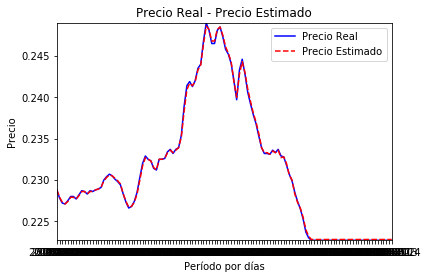

In [24]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from pylab import *

x = dfDays['Periodo por días']
y1 = dfDays['Precio Real']
y2 = dfDays['Precio Estimado']

figure()
plt.plot(x, y1, 'r', color='b')
plt.plot(x, y2, 'r', color='r', linestyle='--')
plt.axis([min(x),max(x),min(y1),max(y1)])
plt.legend()
xlabel('Período por días')
ylabel('Precio')
title('Precio Real - Precio Estimado')
show()